## Imports/loading models

In [3]:
!pip3 install gymnasium
#!pip3 install xgboost
!pip3 install stable-baselines3
!pip3 install stable-baselines3[extra]
#!pip3 install tqdm
#!pip3 install rich
#!pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --user

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#os.environ["WORLD_SIZE"] = "1"
import argparse
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import xgboost as xgb
import pickle
import math

print('Cuda available:', torch.cuda.is_available())

from tqdm import tqdm
from gymnasium import spaces
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from stable_baselines3 import PPO
from torch.utils.data import Dataset
from torch.utils.tensorboard.writer import SummaryWriter 
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.8 MB/s eta 0:00:00 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 117.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 116.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 276.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 181.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 237.3 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: fi

2024-08-09 13:38:10.773909: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 13:38:10.833728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 13:38:10.833789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 13:38:10.835740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 13:38:10.847432: I tensorflow/core/platform/cpu_feature_guar

In [4]:
class Team1Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(2, 16))
        self.pool = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 8))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 8))
        #self.fc1 = nn.Linear(in_features=15360, out_features=1200)  # Fully Connected Layer
        self.fc1 = nn.LazyLinear(out_features=1200)
        self.fc2 = nn.Linear(in_features=1200, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=65)
        self.fc4 = nn.Linear(in_features=65, out_features=self.num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(f'after conv1: {x.shape}')
        x = self.pool(x)
        # print(f'after pool: {x.shape}')
        x = F.relu(self.conv2(x))
        # print(f'after conv2: {x.shape}')
        x = self.pool(x)
        # print(f'after pool: {x.shape}')
        x = F.relu(self.conv3(x))
        # print(f'after conv3: {x.shape}')
        x = self.pool(x)
        # print(f'after pool: {x.shape}')
        x = x.reshape(x.shape[0], -1)
        # print(f'after reshaping: {x.shape}')
        x = F.relu(self.fc1(x))
        # print(f'fc1: {x.shape}')
        x = F.relu(self.fc2(x))
        # print(f'fc2: {x.shape}')
        x = F.relu(self.fc3(x))
        # print(f'fc3: {x.shape}')
        #x = F.relu(self.fc4(x))
        x = self.fc4(x)
        # print(f'fc3: {x.shape}')

        return x

In [5]:
class Team2Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(2, 128, 8, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, 256, 8, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(256),
            nn.Conv1d(256, 512, 8, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(512),
            nn.Conv1d(512, 1024, 8, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(1024),
        )

        self.fc1 = nn.LazyLinear(512, dtype=torch.float32)
        self.fc2 = nn.Linear(512, num_classes, dtype=torch.float32)
        # self.fc = nn.Sequential(
        #     nn.LazyLinear(512, dtype=torch.float32),
        #     nn.ReLU(),
        #     nn.Linear(512, num_classes, dtype=torch.float32),
        #     nn.ReLU(),
        # )

    def forward(self, x):
        x = x.squeeze(1)
        for layer in self.conv_layers:
            x = layer(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        #return F.softmax(x, dim=1)
        return x

In [6]:
# From headley_modrec.py
class Team3Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 16, (2, 16))
        self.conv2 = nn.Conv2d(16, 8, (1, 8))
        self.conv3 = nn.Conv2d(8, 4, (1, 4))
        #self.fc1 = nn.Linear(3996, 512)
        self.fc1 = nn.LazyLinear(out_features=512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, self.num_classes)

        self.activation = {}

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.tanh(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
class Team4Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.re1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.re2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.re3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.re4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.flat = nn.Flatten()
        self.drop1 = nn.Dropout(0.5)
        #self.fc1 = nn.Linear(128 * 256,512)  # I dont exactly know why it is 128x256, but I had to do some debugging and hardcode the required value
        self.fc1 = nn.LazyLinear(out_features=512)

        self.re5 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.re6 = nn.ReLU()
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.re1(self.conv1(x)))
        x = self.pool2(self.re2(self.conv2(x)))
        x = self.pool3(self.re3(self.conv3(x)))
        x = self.pool4(self.re4(self.conv4(x)))
        x = self.flat(x)
        x = self.drop1(x)
        x = self.re5(self.fc1(x))
        x = self.drop2(x)
        x = self.re6(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
sig_types = [['2-ASK', ['ask', 2], 0],
             ['4-ASK', ['ask', 4], 1],
             ['8-ASK', ['ask', 8], 2],
             ['BPSK', ['psk', 2], 3],
             ['QPSK', ['psk', 4], 4],
             ['16-QAM', ['qam', 16], 5],
             ['Tone', ['constant'], 6],
             ['P-FMCW', ['p_fmcw'], 7]]
num_classes = len(sig_types)

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device', device)

team1_model = Team1Model(num_classes)
team1_model.load_state_dict(torch.load('../data/summer_models/team1_model.pt', map_location=torch.device('cpu')))
team1_model.eval()
team1_model.to(device)
print ("loaded team1")
team2_model = Team2Model(num_classes)
team2_model.load_state_dict(torch.load('../data/summer_models/team2_model.pt', map_location=torch.device('cpu')))
team2_model.eval()
team2_model.to(device)
print ("loaded team2")
team3_model = Team3Model(num_classes)
team3_model.load_state_dict(torch.load('../data/summer_models/team3_model.pt', map_location=torch.device('cpu')))
team3_model.eval()
team3_model.to(device)
print ("loaded team3")
team4_model = Team4Model(num_classes)
team4_model.load_state_dict(torch.load('../data/summer_models/team4_model.pt', map_location=torch.device('cpu')))
team4_model.eval()
team4_model.to(device)
print ("loaded team4")

Using device cuda


/tmp/ipykernel_443/3659747126.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  team1_model.load_state_dict(torch.load('../data/summer_models/team1_model.pt', map_locatio

loaded team1
loaded team2
loaded team3


/tmp/ipykernel_443/3659747126.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  team2_model.load_state_dict(torch.load('../data/summer_models/team2_model.pt', map_locatio

loaded team4


In [9]:
#DATA_PATH = os.path.join('fusion_data', 'combined_features_second_to_last_layer.npy')  # Expects file containing numpy array of shape (num_samples, num_features)
#LABELS_PATH = os.path.join('fusion_data', 'labels.npy')  # Expects file containing numpy array of shape (num_samples, num_classes)

NUM_FEATS_T1 = 65
NUM_FEATS_T2 = 512
NUM_FEATS_T3 = 64
NUM_FEATS_T4 = 256
ARRAY_START_IDX_T1 = 0
ARRAY_START_IDX_T2 = NUM_FEATS_T1
ARRAY_START_IDX_T3 = NUM_FEATS_T1 + NUM_FEATS_T2
ARRAY_START_IDX_T4 = NUM_FEATS_T1 + NUM_FEATS_T2 + NUM_FEATS_T3

TEAM1_OBS_INT = 2048
TEAM2_OBS_INT = 1024
TEAM3_OBS_INT = 512
TEAM4_OBS_INT = 256

#data = torch.from_numpy(np.load(DATA_PATH))
#labels = torch.from_numpy(np.load(LABELS_PATH))

team1_test_dir = os.path.join('../data/dataset', 'team1', 'test')
team2_test_dir = os.path.join('../data/dataset', 'team2', 'test')
team3_test_dir = os.path.join('../data/dataset', 'team3', 'test')
team4_test_dir = os.path.join('../data/dataset', 'team4', 'test')

# Using second to last layer for each model
team1_selected_layer = getattr(team1_model, 'fc3')
team2_selected_layer = getattr(team2_model, 'fc1')
team3_selected_layer = getattr(team3_model, 'fc3')
team4_selected_layer = getattr(team4_model, 'fc2')

In [10]:
MODELS_OBS_INT = 2048
def load_data(channel_path, batch_size, num_batches, num_train_examples, data_obs_int):
    training_data = np.zeros((num_train_examples, 1, 2, MODELS_OBS_INT), dtype=np.float32)

    last_index = 0
    for k in range(num_batches):
        # This is used if we have a labeldata folder that stores class labels
        label_df = pd.read_csv(f"{channel_path}/labeldata/example_{k + 1}.csv")

        num_nans = 0
        iq_file_name = f"{channel_path}/iqdata/example_{k + 1}.dat"
        iq_data = np.fromfile(iq_file_name, np.csingle)
        iq_data = np.reshape(iq_data, (-1, data_obs_int))  # Turn the IQ data into chunks of (chunk size) x (data_obs_int)
        for j in range(iq_data.shape[0]):
            # Check if the current row contains NaN values
            if np.isnan(np.sum(iq_data[j][:])):    
                num_nans += 1
            else:
                iq_array_norm = iq_data[j][:] / np.max(np.abs(iq_data[j][:]))  # Normalize the observation
                iq_array = np.vstack((iq_array_norm.real, iq_array_norm.imag))  # Separate into 2 subarrays - 1 with only real (in-phase), the other only imaginary (quadrature)

                # Pad the iq array with zeros to meet the observation length requirement
                # This is needed because the CNN models have a fixed input size
                iq_array = np.pad(iq_array, ((0, 0), (0, MODELS_OBS_INT - iq_array[0].size)), mode='constant', constant_values=0)

                training_data[last_index, 0, :, :] = iq_array
            last_index += 1
        
        if num_nans > 0:
            print(f'Found {num_nans} rows containing NaNs in {iq_file_name}')
    return torch.utils.data.DataLoader([training_data[i] for i in range(num_train_examples)], batch_size=batch_size, shuffle=False)

def load_labels(channel_path, batch_size, num_batches, num_train_examples, data_obs_int):
    training_labels = torch.stack([torch.nn.functional.one_hot(torch.tensor(pd.read_csv(os.path.join(channel_path, f'labeldata/example_{i+1}.csv')).iloc[:,0])) for i in range(num_batches)])
    return training_labels

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

## Plot feature contribution over SNRs

Loaded data for SNR 3
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:03, 1619.00it/s]
Team 2: 5000it [00:02, 2186.56it/s]
Team 3: 5000it [00:01, 4545.95it/s]
Team 4: 5000it [00:01, 2550.03it/s]
Getting model importances: 100%|██████████| 10/10 [00:45<00:00,  4.59s/it]


Loaded data for SNR 6
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2929.94it/s]
Team 2: 5000it [00:02, 2290.22it/s]
Team 3: 5000it [00:01, 4394.55it/s]
Team 4: 5000it [00:02, 2154.83it/s]
Getting model importances: 100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


Loaded data for SNR 7
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2887.95it/s]
Team 2: 5000it [00:03, 1595.03it/s]
Team 3: 5000it [00:01, 4500.69it/s]
Team 4: 5000it [00:01, 2589.49it/s]
Getting model importances: 100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


Loaded data for SNR 9
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2251.25it/s]
Team 2: 5000it [00:02, 2305.90it/s]
Team 3: 5000it [00:01, 4529.42it/s]
Team 4: 5000it [00:01, 2593.19it/s]
Getting model importances: 100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


Loaded data for SNR 12
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2711.35it/s]
Team 2: 5000it [00:02, 2307.09it/s]
Team 3: 5000it [00:01, 4350.95it/s]
Team 4: 5000it [00:01, 2625.87it/s]
Getting model importances: 100%|██████████| 10/10 [00:39<00:00,  3.91s/it]


Loaded data for SNR 4
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1928.79it/s]
Team 2: 5000it [00:02, 2211.78it/s]
Team 3: 5000it [00:01, 4150.36it/s]
Team 4: 5000it [00:02, 2482.86it/s]
Getting model importances: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


Loaded data for SNR 0
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1973.06it/s]
Team 2: 5000it [00:02, 2275.02it/s]
Team 3: 5000it [00:01, 4313.23it/s]
Team 4: 5000it [00:01, 2590.69it/s]
Getting model importances: 100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


Loaded data for SNR 11
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1794.01it/s]
Team 2: 5000it [00:03, 1619.77it/s]
Team 3: 5000it [00:02, 2403.95it/s]
Team 4: 5000it [00:01, 2545.18it/s]
Getting model importances: 100%|██████████| 10/10 [00:38<00:00,  3.83s/it]


Loaded data for SNR 13
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2956.20it/s]
Team 2: 5000it [00:02, 2174.52it/s]
Team 3: 5000it [00:01, 4272.18it/s]
Team 4: 5000it [00:01, 2562.35it/s]
Getting model importances: 100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


Loaded data for SNR 10
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:03, 1548.21it/s]
Team 2: 5000it [00:02, 2293.88it/s]
Team 3: 5000it [00:01, 2738.85it/s]
Team 4: 5000it [00:01, 2611.67it/s]
Getting model importances: 100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


Loaded data for SNR 8
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2119.25it/s]
Team 2: 5000it [00:02, 1694.72it/s]
Team 3: 5000it [00:01, 4211.54it/s]
Team 4: 5000it [00:01, 2605.28it/s]
Getting model importances: 100%|██████████| 10/10 [00:39<00:00,  3.92s/it]


Loaded data for SNR 2
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1795.64it/s]
Team 2: 5000it [00:02, 1822.42it/s]
Team 3: 5000it [00:01, 4418.28it/s]
Team 4: 5000it [00:02, 1935.02it/s]
Getting model importances: 100%|██████████| 10/10 [00:49<00:00,  4.98s/it]


Loaded data for SNR 5
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2576.88it/s]
Team 2: 5000it [00:02, 1915.27it/s]
Team 3: 5000it [00:01, 4413.38it/s]
Team 4: 5000it [00:01, 2636.90it/s]
Getting model importances: 100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


Loaded data for SNR 14
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2879.37it/s]
Team 2: 5000it [00:02, 1870.09it/s]
Team 3: 5000it [00:01, 4088.59it/s]
Team 4: 5000it [00:01, 2579.07it/s]
Getting model importances: 100%|██████████| 10/10 [00:41<00:00,  4.15s/it]


Loaded data for SNR 1
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1873.18it/s]
Team 2: 5000it [00:02, 2280.57it/s]
Team 3: 5000it [00:01, 4269.66it/s]
Team 4: 5000it [00:01, 2592.47it/s]
Getting model importances: 100%|██████████| 10/10 [00:51<00:00,  5.11s/it]

    snr    Team 1    Team 2    Team 3    Team 4
0     3  0.225016  0.754917  0.008419  0.011648
1     6  0.364208  0.623961  0.005804  0.006026
2     7  0.633555  0.359690  0.004437  0.002318
3     9  0.627007  0.367490  0.002494  0.003009
4    12  0.775871  0.206391  0.002247  0.015491
5     4  0.364841  0.619435  0.005335  0.010388
6     0  0.069275  0.875950  0.015678  0.039098
7    11  0.785551  0.207762  0.001758  0.004930
8    13  0.859635  0.133224  0.003086  0.004055
9    10  0.744849  0.247450  0.002120  0.005581
10    8  0.778494  0.208123  0.008762  0.004621
11    2  0.223426  0.750003  0.008693  0.017877
12    5  0.458125  0.529415  0.002892  0.009568
13   14  0.899094  0.064793  0.000649  0.035463
14    1  0.082423  0.886347  0.008989  0.022241


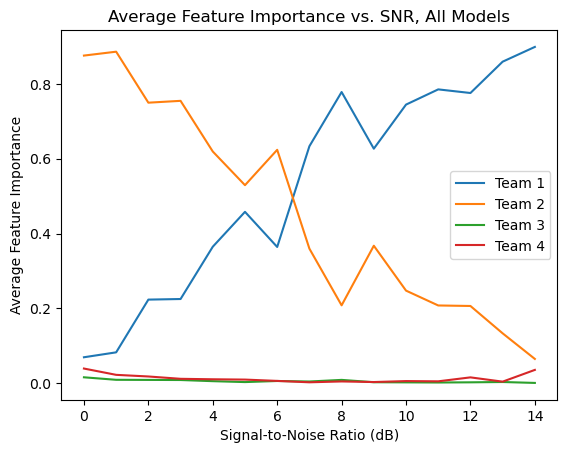

In [12]:
num_batches = 1
CHUNK_SIZE = 5000
num_examples = num_batches * CHUNK_SIZE
OBS_INT = 2048
NUM_ITERATIONS = 10

team1_snr_dir = os.path.join(team1_test_dir, 'snr')
team2_snr_dir = os.path.join(team2_test_dir, 'snr')
team3_snr_dir = os.path.join(team3_test_dir, 'snr')
team4_snr_dir = os.path.join(team4_test_dir, 'snr')

snr_folder_names = []
processed_snrs = []
team1_importances = []
team2_importances = []
team3_importances = []
team4_importances = []

# Iterate over every folder in the SNR directory
for path, subdirs, files in os.walk(team1_snr_dir):
    # If we're in the top-level snr directory, get the values from all the folder names
    if os.path.basename(path) == 'snr':
        snr_folder_names = subdirs
    elif os.path.basename(path) in snr_folder_names:
        snr = int(os.path.basename(path))
        
        # Load the IQ and label data for this SNR
        labels = load_labels(path, 1, num_batches, num_examples, OBS_INT)        
        team1_dataloader = load_data(os.path.join(team1_snr_dir, str(snr)), 1, num_batches, num_examples, TEAM1_OBS_INT)
        team2_dataloader = load_data(os.path.join(team2_snr_dir, str(snr)), 1, num_batches, num_examples, TEAM2_OBS_INT)
        team3_dataloader = load_data(os.path.join(team3_snr_dir, str(snr)), 1, num_batches, num_examples, TEAM3_OBS_INT)
        team4_dataloader = load_data(os.path.join(team4_snr_dir, str(snr)), 1, num_batches, num_examples, TEAM4_OBS_INT)
        print(f'Loaded data for SNR {snr}')
        
        count_all_zeros = 0
        labels = np.squeeze(labels.numpy())
        for i in range(len(labels)):
            if np.sum(labels[i]) == 0:
                count_all_zeros += 1
        print("Number of missing labels:", count_all_zeros)
        
        print('Processing data...')
        # Extract features from Team 1's model
        team1_selected_layer.register_forward_hook(get_features('feats'))
        team1_model.to(device)
        team1_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team1_dataloader), desc='Team 1'):
            with torch.inference_mode():
                preds = team1_model(inputs.to(device))
            team1_feats_list.append(features['feats'].cpu().numpy())
        team1_feats_list = np.concatenate(team1_feats_list)
        features1 = np.array(team1_feats_list)
        features1 = torch.tensor(features1)
        features1 = features1.reshape(-1, features1.shape[-1])
        if features1.shape[1] != NUM_FEATS_T1:
            print(f'Error: Number of features extracted from team 1 model doesn\'t match expected value ({NUM_FEATS_T1})')
        
        # Extract features from Team 2's model
        team2_selected_layer.register_forward_hook(get_features('feats'))
        team2_model.to(device)
        team2_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team2_dataloader), desc='Team 2'):
            with torch.inference_mode():
                preds = team2_model(inputs.to(device))
            team2_feats_list.append(features['feats'].cpu().numpy())
        team2_feats_list = np.concatenate(team2_feats_list)
        features2 = np.array(team2_feats_list)
        features2 = torch.tensor(features2)
        features2 = features2.reshape(-1, features2.shape[-1])
        if features2.shape[1] != NUM_FEATS_T2:
            print(f'Error: Number of features extracted from team 2 model doesn\'t match expected value ({NUM_FEATS_T2})')
        
        # Extract features from Team 3's model
        team3_selected_layer.register_forward_hook(get_features('feats'))
        team3_model.to(device)
        team3_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team3_dataloader), desc='Team 3'):
            with torch.inference_mode():
                preds = team3_model(inputs.to(device))
            team3_feats_list.append(features['feats'].cpu().numpy())
        team3_feats_list = np.concatenate(team3_feats_list)
        features3 = np.array(team3_feats_list)
        features3 = torch.tensor(features3)
        features3 = features3.reshape(-1, features3.shape[-1])
        if features3.shape[1] != NUM_FEATS_T3:
            print(f'Error: Number of features extracted from team 3 model doesn\'t match expected value ({NUM_FEATS_T3})')
        
        # Extract features from team 4's model
        team4_selected_layer.register_forward_hook(get_features('feats'))
        team4_model.to(device)
        team4_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team4_dataloader), desc='Team 4'):
            with torch.inference_mode():
                preds = team4_model(inputs.to(device))
            team4_feats_list.append(features['feats'].cpu().numpy())
        team4_feats_list = np.concatenate(team4_feats_list)
        features4 = np.array(team4_feats_list)
        features4 = torch.tensor(features4)
        features4 = features4.reshape(-1, features4.shape[-1])
        if features4.shape[1] != NUM_FEATS_T4:
            print(f'Error: Number of features extracted from team 4 model doesn\'t match expected value ({NUM_FEATS_T4})')
        
        combined_tensor = torch.cat((features1, features2, features3, features4), dim=1)
        
        # Note: Decision tree classifiers use a stochastic algorithm so we take model importance as the average over multiple iterations
        team1_avg_importance = 0.0
        team2_avg_importance = 0.0
        team3_avg_importance = 0.0
        team4_avg_importance = 0.0
        for i in tqdm(range(NUM_ITERATIONS), desc='Getting model importances'):
            model = DecisionTreeClassifier()
            model.fit(combined_tensor, labels)
            importances = model.feature_importances_
            importances = np.array(importances)
        
            team1_avg_importance += np.sum(importances[ARRAY_START_IDX_T1:ARRAY_START_IDX_T2])
            team2_avg_importance += np.sum(importances[ARRAY_START_IDX_T2:ARRAY_START_IDX_T3])
            team3_avg_importance += np.sum(importances[ARRAY_START_IDX_T3:ARRAY_START_IDX_T4])
            team4_avg_importance += np.sum(importances[ARRAY_START_IDX_T4:len(importances)])
        team1_avg_importance /= NUM_ITERATIONS
        team2_avg_importance /= NUM_ITERATIONS
        team3_avg_importance /= NUM_ITERATIONS
        team4_avg_importance /= NUM_ITERATIONS
            
        importances_sum = team1_avg_importance + team2_avg_importance + team3_avg_importance + team4_avg_importance
        #print(f'Team 1 avg. importance: {team1_avg_importance}')
        #print(f'Team 2 avg. importance: {team2_avg_importance}')
        #print(f'Team 3 avg. importance: {team3_avg_importance}')
        #print(f'Team 4 avg. importance: {team4_avg_importance}')
        if not math.isclose(1.0, importances_sum, abs_tol=0.01):
            print(f'Error: Importances do not sum to 1.0 (Was {importances_sum})')
        
        processed_snrs.append(snr)
        team1_importances.append(team1_avg_importance)
        team2_importances.append(team2_avg_importance)
        team3_importances.append(team3_avg_importance)
        team4_importances.append(team4_avg_importance)

df = pd.DataFrame(
    {'snr': processed_snrs,
     'Team 1': team1_importances,
     'Team 2': team2_importances,
     'Team 3': team3_importances,
     'Team 4': team4_importances,
    })
print(df.to_string())
df.sort_values(by=['snr'], inplace=True)
df.plot.line(x='snr')

plt.ylabel('Average Feature Importance')
plt.xlabel('Signal-to-Noise Ratio (dB)')
plt.title('Average Feature Importance vs. SNR, All Models')
plt.savefig('../data/fusion_plots/feature_importances/avg_feat_importance_snr.png')
plt.show()

## Plot feature contribution over bandwidths

Found 4 rows containing NaNs in ../data/dataset/team3/test/bandwidths/0.095/iqdata/example_1.dat
Found 4 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.095/iqdata/example_1.dat
Loaded data for bandwidth 0.095
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1974.41it/s]
Team 2: 5000it [00:02, 2296.04it/s]
Team 3: 5000it [00:02, 2338.11it/s]
Team 4: 5000it [00:02, 2421.47it/s]
Getting model importances: 100%|██████████| 10/10 [00:58<00:00,  5.85s/it]


Loaded data for bandwidth 0.41
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1922.47it/s]
Team 2: 5000it [00:02, 2327.60it/s]
Team 3: 5000it [00:01, 4400.90it/s]
Team 4: 5000it [00:01, 2596.10it/s]
Getting model importances: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


Found 1 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.11750000000000001/iqdata/example_1.dat
Loaded data for bandwidth 0.11750000000000001
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2117.21it/s]
Team 2: 5000it [00:02, 2293.83it/s]
Team 3: 5000it [00:01, 4208.16it/s]
Team 4: 5000it [00:01, 2600.97it/s]
Getting model importances: 100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


Found 10 rows containing NaNs in ../data/dataset/team3/test/bandwidths/0.05/iqdata/example_1.dat
Found 10 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.05/iqdata/example_1.dat
Loaded data for bandwidth 0.05
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2168.03it/s]
Team 2: 5000it [00:03, 1623.39it/s]
Team 3: 5000it [00:01, 3841.71it/s]
Team 4: 5000it [00:02, 1920.19it/s]
Getting model importances: 100%|██████████| 10/10 [01:14<00:00,  7.44s/it]


Loaded data for bandwidth 0.2975
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1987.56it/s]
Team 2: 5000it [00:02, 2198.78it/s]
Team 3: 5000it [00:01, 4330.90it/s]
Team 4: 5000it [00:01, 2547.56it/s]
Getting model importances: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


Loaded data for bandwidth 0.27499999999999997
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1876.41it/s]
Team 2: 5000it [00:02, 2307.30it/s]
Team 3: 5000it [00:02, 2311.33it/s]
Team 4: 5000it [00:03, 1655.96it/s]
Getting model importances: 100%|██████████| 10/10 [00:37<00:00,  3.71s/it]


Found 1 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.185/iqdata/example_1.dat
Loaded data for bandwidth 0.185
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2343.63it/s]
Team 2: 5000it [00:02, 2292.29it/s]
Team 3: 5000it [00:01, 4237.38it/s]
Team 4: 5000it [00:01, 2603.71it/s]
Getting model importances: 100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


Loaded data for bandwidth 0.5
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2927.15it/s]
Team 2: 5000it [00:02, 2283.33it/s]
Team 3: 5000it [00:01, 4141.23it/s]
Team 4: 5000it [00:01, 2565.16it/s]
Getting model importances: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


Loaded data for bandwidth 0.4775
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2043.16it/s]
Team 2: 5000it [00:02, 2284.37it/s]
Team 3: 5000it [00:01, 4028.13it/s]
Team 4: 5000it [00:01, 2565.37it/s]
Getting model importances: 100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


Loaded data for bandwidth 0.20750000000000002
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2952.15it/s]
Team 2: 5000it [00:02, 2274.74it/s]
Team 3: 5000it [00:01, 4213.08it/s]
Team 4: 5000it [00:01, 2602.95it/s]
Getting model importances: 100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


Found 2 rows containing NaNs in ../data/dataset/team3/test/bandwidths/0.07250000000000001/iqdata/example_1.dat
Found 5 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.07250000000000001/iqdata/example_1.dat
Loaded data for bandwidth 0.07250000000000001
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2883.27it/s]
Team 2: 5000it [00:02, 2250.19it/s]
Team 3: 5000it [00:02, 2269.62it/s]
Team 4: 5000it [00:01, 2508.70it/s]
Getting model importances: 100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Loaded data for bandwidth 0.2525
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2869.75it/s]
Team 2: 5000it [00:02, 2280.24it/s]
Team 3: 5000it [00:02, 2438.75it/s]
Team 4: 5000it [00:01, 2551.53it/s]
Getting model importances: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


Loaded data for bandwidth 0.32
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2927.29it/s]
Team 2: 5000it [00:03, 1555.66it/s]
Team 3: 5000it [00:01, 4143.36it/s]
Team 4: 5000it [00:01, 2557.99it/s]
Getting model importances: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


Loaded data for bandwidth 0.22999999999999998
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2935.90it/s]
Team 2: 5000it [00:02, 2253.99it/s]
Team 3: 5000it [00:01, 2927.42it/s]
Team 4: 5000it [00:01, 2528.37it/s]
Getting model importances: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


Found 1 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.14/iqdata/example_1.dat
Loaded data for bandwidth 0.14
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2038.50it/s]
Team 2: 5000it [00:02, 2240.33it/s]
Team 3: 5000it [00:02, 2227.70it/s]
Team 4: 5000it [00:02, 2442.41it/s]
Getting model importances: 100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


Loaded data for bandwidth 0.365
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1897.59it/s]
Team 2: 5000it [00:02, 2268.91it/s]
Team 3: 5000it [00:01, 4061.43it/s]
Team 4: 5000it [00:02, 1791.49it/s]
Getting model importances: 100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


Loaded data for bandwidth 0.34249999999999997
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1877.67it/s]
Team 2: 5000it [00:03, 1461.39it/s]
Team 3: 5000it [00:01, 4074.75it/s]
Team 4: 5000it [00:01, 2571.46it/s]
Getting model importances: 100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


Loaded data for bandwidth 0.16249999999999998
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2908.02it/s]
Team 2: 5000it [00:02, 2017.60it/s]
Team 3: 5000it [00:02, 2164.94it/s]
Team 4: 5000it [00:01, 2555.53it/s]
Getting model importances: 100%|██████████| 10/10 [00:38<00:00,  3.90s/it]


Loaded data for bandwidth 0.4325
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1899.62it/s]
Team 2: 5000it [00:02, 2188.87it/s]
Team 3: 5000it [00:01, 4099.72it/s]
Team 4: 5000it [00:01, 2598.57it/s]
Getting model importances: 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Loaded data for bandwidth 0.38749999999999996
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2742.94it/s]
Team 2: 5000it [00:03, 1474.84it/s]
Team 3: 5000it [00:01, 4010.82it/s]
Team 4: 5000it [00:01, 2602.91it/s]
Getting model importances: 100%|██████████| 10/10 [00:34<00:00,  3.40s/it]


Loaded data for bandwidth 0.45499999999999996
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2924.05it/s]
Team 2: 5000it [00:02, 2283.91it/s]
Team 3: 5000it [00:01, 4161.62it/s]
Team 4: 5000it [00:01, 2554.97it/s]
Getting model importances: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it]

    bandwidth    Team 1    Team 2    Team 3    Team 4
0      0.0950  0.881243  0.083758  0.011916  0.023083
1      0.4100  0.847636  0.099466  0.003974  0.048924
2      0.1175  0.917435  0.059297  0.009666  0.013602
3      0.0500  0.499264  0.295551  0.073040  0.132145
4      0.2975  0.950230  0.042184  0.003596  0.003991
5      0.2750  0.893273  0.097839  0.005022  0.003866
6      0.1850  0.952676  0.033085  0.003683  0.010557
7      0.5000  0.836135  0.072357  0.001237  0.090272
8      0.4775  0.869748  0.126499  0.001779  0.001974
9      0.2075  0.782023  0.202421  0.006452  0.009103
10     0.0725  0.800315  0.130360  0.024822  0.044502
11     0.2525  0.764030  0.222881  0.003538  0.009551
12     0.3200  0.866155  0.116246  0.001514  0.016085
13     0.2300  0.943700  0.044170  0.004915  0.007215
14     0.1400  0.927101  0.044700  0.007732  0.020467
15     0.3650  0.880615  0.088383  0.000335  0.030667
16     0.3425  0.863275  0.087077  0.004301  0.045346
17     0.1625  0.946184  0.0

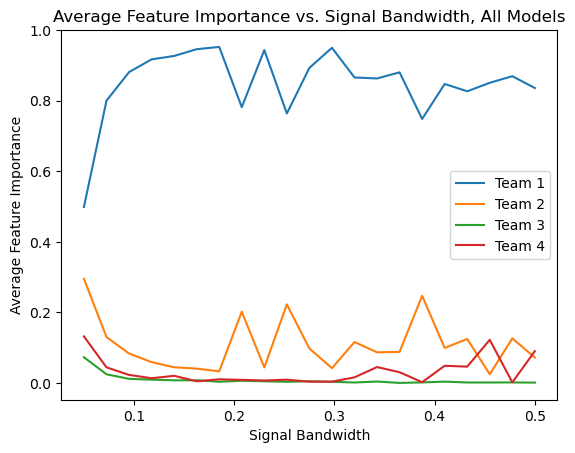

In [13]:
num_batches = 1
CHUNK_SIZE = 5000
num_examples = num_batches * CHUNK_SIZE
OBS_INT = 2048
NUM_ITERATIONS = 10

team1_bandwidth_dir = os.path.join(team1_test_dir, 'bandwidths')
team2_bandwidth_dir = os.path.join(team2_test_dir, 'bandwidths')
team3_bandwidth_dir = os.path.join(team3_test_dir, 'bandwidths')
team4_bandwidth_dir = os.path.join(team4_test_dir, 'bandwidths')

bandwidth_folder_names = []
processed_bandwidths = []
team1_importances = []
team2_importances = []
team3_importances = []
team4_importances = []

# Iterate over every folder in the bandwidth directory
for path, subdirs, files in os.walk(team1_bandwidth_dir):
    # If we're in the top-level bandwidth directory, get the values from all the folder names
    if os.path.basename(path) == 'bandwidths':
        bandwidth_folder_names = subdirs
    elif os.path.basename(path) in bandwidth_folder_names:
        bandwidth = float(os.path.basename(path))
        
        # Load the IQ and label data for this bandwidth
        labels = load_labels(path, 1, num_batches, num_examples, OBS_INT)        
        team1_dataloader = load_data(os.path.join(team1_bandwidth_dir, str(bandwidth)), 1, num_batches, num_examples, TEAM1_OBS_INT)
        team2_dataloader = load_data(os.path.join(team2_bandwidth_dir, str(bandwidth)), 1, num_batches, num_examples, TEAM2_OBS_INT)
        team3_dataloader = load_data(os.path.join(team3_bandwidth_dir, str(bandwidth)), 1, num_batches, num_examples, TEAM3_OBS_INT)
        team4_dataloader = load_data(os.path.join(team4_bandwidth_dir, str(bandwidth)), 1, num_batches, num_examples, TEAM4_OBS_INT)
        print(f'Loaded data for bandwidth {bandwidth}')
        
        count_all_zeros = 0
        labels = np.squeeze(labels.numpy())
        for i in range(len(labels)):
            if np.sum(labels[i]) == 0:
                count_all_zeros += 1
        print("Number of missing labels:", count_all_zeros)
        
        print('Processing data...')
        # Extract features from Team 1's model
        team1_selected_layer.register_forward_hook(get_features('feats'))
        team1_model.to(device)
        team1_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team1_dataloader), desc='Team 1'):
            with torch.inference_mode():
                preds = team1_model(inputs.to(device))
            team1_feats_list.append(features['feats'].cpu().numpy())
        team1_feats_list = np.concatenate(team1_feats_list)
        features1 = np.array(team1_feats_list)
        features1 = torch.tensor(features1)
        features1 = features1.reshape(-1, features1.shape[-1])
        if features1.shape[1] != NUM_FEATS_T1:
            print(f'Error: Number of features extracted from team 1 model doesn\'t match expected value ({NUM_FEATS_T1})')
        
        # Extract features from Team 2's model
        team2_selected_layer.register_forward_hook(get_features('feats'))
        team2_model.to(device)
        team2_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team2_dataloader), desc='Team 2'):
            with torch.inference_mode():
                preds = team2_model(inputs.to(device))
            team2_feats_list.append(features['feats'].cpu().numpy())
        team2_feats_list = np.concatenate(team2_feats_list)
        features2 = np.array(team2_feats_list)
        features2 = torch.tensor(features2)
        features2 = features2.reshape(-1, features2.shape[-1])
        if features2.shape[1] != NUM_FEATS_T2:
            print(f'Error: Number of features extracted from team 2 model doesn\'t match expected value ({NUM_FEATS_T2})')
        
        # Extract features from Team 3's model
        team3_selected_layer.register_forward_hook(get_features('feats'))
        team3_model.to(device)
        team3_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team3_dataloader), desc='Team 3'):
            with torch.inference_mode():
                preds = team3_model(inputs.to(device))
            team3_feats_list.append(features['feats'].cpu().numpy())
        team3_feats_list = np.concatenate(team3_feats_list)
        features3 = np.array(team3_feats_list)
        features3 = torch.tensor(features3)
        features3 = features3.reshape(-1, features3.shape[-1])
        if features3.shape[1] != NUM_FEATS_T3:
            print(f'Error: Number of features extracted from team 3 model doesn\'t match expected value ({NUM_FEATS_T3})')
        
        # Extract features from team 4's model
        team4_selected_layer.register_forward_hook(get_features('feats'))
        team4_model.to(device)
        team4_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team4_dataloader), desc='Team 4'):
            with torch.inference_mode():
                preds = team4_model(inputs.to(device))
            team4_feats_list.append(features['feats'].cpu().numpy())
        team4_feats_list = np.concatenate(team4_feats_list)
        features4 = np.array(team4_feats_list)
        features4 = torch.tensor(features4)
        features4 = features4.reshape(-1, features4.shape[-1])
        if features4.shape[1] != NUM_FEATS_T4:
            print(f'Error: Number of features extracted from team 4 model doesn\'t match expected value ({NUM_FEATS_T4})')
        
        combined_tensor = torch.cat((features1, features2, features3, features4), dim=1)
        
        # Note: Decision tree classifiers use a stochastic algorithm so we take model importance as the average over multiple iterations
        team1_avg_importance = 0.0
        team2_avg_importance = 0.0
        team3_avg_importance = 0.0
        team4_avg_importance = 0.0
        for i in tqdm(range(NUM_ITERATIONS), desc='Getting model importances'):
            model = DecisionTreeClassifier()
            model.fit(combined_tensor, labels)
            importances = model.feature_importances_
            importances = np.array(importances)
        
            team1_avg_importance += np.sum(importances[ARRAY_START_IDX_T1:ARRAY_START_IDX_T2])
            team2_avg_importance += np.sum(importances[ARRAY_START_IDX_T2:ARRAY_START_IDX_T3])
            team3_avg_importance += np.sum(importances[ARRAY_START_IDX_T3:ARRAY_START_IDX_T4])
            team4_avg_importance += np.sum(importances[ARRAY_START_IDX_T4:len(importances)])
        team1_avg_importance /= NUM_ITERATIONS
        team2_avg_importance /= NUM_ITERATIONS
        team3_avg_importance /= NUM_ITERATIONS
        team4_avg_importance /= NUM_ITERATIONS
            
        importances_sum = team1_avg_importance + team2_avg_importance + team3_avg_importance + team4_avg_importance
        #print(f'Team 1 avg. importance: {team1_avg_importance}')
        #print(f'Team 2 avg. importance: {team2_avg_importance}')
        #print(f'Team 3 avg. importance: {team3_avg_importance}')
        #print(f'Team 4 avg. importance: {team4_avg_importance}')
        if not math.isclose(1.0, importances_sum, abs_tol=0.01):
            print(f'Error: Importances do not sum to 1.0 (Was {importances_sum})')
        
        processed_bandwidths.append(bandwidth)
        team1_importances.append(team1_avg_importance)
        team2_importances.append(team2_avg_importance)
        team3_importances.append(team3_avg_importance)
        team4_importances.append(team4_avg_importance)

df = pd.DataFrame(
    {'bandwidth': processed_bandwidths,
     'Team 1': team1_importances,
     'Team 2': team2_importances,
     'Team 3': team3_importances,
     'Team 4': team4_importances,
    })
print(df.to_string())
df.sort_values(by=['bandwidth'], inplace=True)
df.plot.line(x='bandwidth')

plt.ylabel('Average Feature Importance')
plt.xlabel('Signal Bandwidth')
plt.title('Average Feature Importance vs. Signal Bandwidth, All Models')
plt.savefig('../data/fusion_plots/feature_importances/avg_feat_importance_bandwidth.png')
plt.show()

## Plot feature contribution over center frequencies

Loaded data for center frequency -0.08
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2019.94it/s]
Team 2: 5000it [00:03, 1285.58it/s]
Team 3: 5000it [00:01, 4138.79it/s]
Team 4: 5000it [00:01, 2564.28it/s]
Getting model importances: 100%|██████████| 10/10 [01:01<00:00,  6.13s/it]


Loaded data for center frequency -0.04000000000000001
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2918.29it/s]
Team 2: 5000it [00:02, 2308.54it/s]
Team 3: 5000it [00:01, 3091.10it/s]
Team 4: 5000it [00:01, 2608.89it/s]
Getting model importances: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]


Loaded data for center frequency 0.06
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1967.60it/s]
Team 2: 5000it [00:02, 2294.66it/s]
Team 3: 5000it [00:01, 4160.61it/s]
Team 4: 5000it [00:01, 2550.79it/s]
Getting model importances: 100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Loaded data for center frequency 0.07
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2098.08it/s]
Team 2: 5000it [00:02, 1709.97it/s]
Team 3: 5000it [00:02, 2258.88it/s]
Team 4: 5000it [00:01, 2590.16it/s]
Getting model importances: 100%|██████████| 10/10 [00:57<00:00,  5.76s/it]


Loaded data for center frequency 0.009999999999999995
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2173.63it/s]
Team 2: 5000it [00:03, 1539.55it/s]
Team 3: 5000it [00:01, 3968.99it/s]
Team 4: 5000it [00:01, 2614.99it/s]
Getting model importances: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Loaded data for center frequency -0.010000000000000009
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2932.00it/s]
Team 2: 5000it [00:03, 1634.68it/s]
Team 3: 5000it [00:01, 4045.76it/s]
Team 4: 5000it [00:01, 2590.38it/s]
Getting model importances: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


Loaded data for center frequency -0.060000000000000005
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2959.98it/s]
Team 2: 5000it [00:02, 2236.98it/s]
Team 3: 5000it [00:01, 4078.41it/s]
Team 4: 5000it [00:01, 2607.68it/s]
Getting model importances: 100%|██████████| 10/10 [01:05<00:00,  6.55s/it]


Loaded data for center frequency 0.1
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2882.18it/s]
Team 2: 5000it [00:02, 2259.04it/s]
Team 3: 5000it [00:01, 3947.17it/s]
Team 4: 5000it [00:01, 2573.53it/s]
Getting model importances: 100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Loaded data for center frequency -0.1
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2921.10it/s]
Team 2: 5000it [00:02, 2290.67it/s]
Team 3: 5000it [00:01, 3908.54it/s]
Team 4: 5000it [00:02, 1962.79it/s]
Getting model importances: 100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


Loaded data for center frequency 0.07999999999999999
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2844.79it/s]
Team 2: 5000it [00:02, 2272.84it/s]
Team 3: 5000it [00:01, 3889.72it/s]
Team 4: 5000it [00:01, 2556.95it/s]
Getting model importances: 100%|██████████| 10/10 [01:01<00:00,  6.20s/it]


Loaded data for center frequency -0.020000000000000004
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2061.70it/s]
Team 2: 5000it [00:03, 1398.99it/s]
Team 3: 5000it [00:01, 3993.32it/s]
Team 4: 5000it [00:01, 2562.70it/s]
Getting model importances: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Loaded data for center frequency 0.04999999999999999
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2944.19it/s]
Team 2: 5000it [00:02, 1803.37it/s]
Team 3: 5000it [00:01, 3853.38it/s]
Team 4: 5000it [00:01, 2509.39it/s]
Getting model importances: 100%|██████████| 10/10 [00:59<00:00,  5.91s/it]


Loaded data for center frequency -0.03
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2677.63it/s]
Team 2: 5000it [00:02, 2203.29it/s]
Team 3: 5000it [00:01, 3863.78it/s]
Team 4: 5000it [00:01, 2518.73it/s]
Getting model importances: 100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


Loaded data for center frequency -0.07
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2392.35it/s]
Team 2: 5000it [00:02, 2179.54it/s]
Team 3: 5000it [00:01, 3836.77it/s]
Team 4: 5000it [00:02, 2493.42it/s]
Getting model importances: 100%|██████████| 10/10 [01:08<00:00,  6.88s/it]


Loaded data for center frequency -0.05
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2584.43it/s]
Team 2: 5000it [00:02, 1934.17it/s]
Team 3: 5000it [00:01, 3070.69it/s]
Team 4: 5000it [00:02, 1969.35it/s]
Getting model importances: 100%|██████████| 10/10 [00:57<00:00,  5.76s/it]


Loaded data for center frequency 0.03
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2585.74it/s]
Team 2: 5000it [00:02, 2206.68it/s]
Team 3: 5000it [00:01, 3966.72it/s]
Team 4: 5000it [00:02, 1985.01it/s]
Getting model importances: 100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


Loaded data for center frequency 0.09
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:03, 1612.39it/s]
Team 2: 5000it [00:02, 2208.46it/s]
Team 3: 5000it [00:01, 3828.83it/s]
Team 4: 5000it [00:02, 2404.64it/s]
Getting model importances: 100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


Loaded data for center frequency 0.01999999999999999
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1740.70it/s]
Team 2: 5000it [00:03, 1438.65it/s]
Team 3: 5000it [00:02, 2295.21it/s]
Team 4: 5000it [00:02, 2487.36it/s]
Getting model importances: 100%|██████████| 10/10 [00:49<00:00,  4.98s/it]


Loaded data for center frequency -0.09000000000000001
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2929.36it/s]
Team 2: 5000it [00:02, 1773.87it/s]
Team 3: 5000it [00:01, 2903.28it/s]
Team 4: 5000it [00:01, 2573.67it/s]
Getting model importances: 100%|██████████| 10/10 [00:54<00:00,  5.47s/it]


Loaded data for center frequency 0.04000000000000001
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2226.48it/s]
Team 2: 5000it [00:02, 2219.54it/s]
Team 3: 5000it [00:01, 3849.01it/s]
Team 4: 5000it [00:01, 2607.42it/s]
Getting model importances: 100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


Loaded data for center frequency 0.0
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2984.90it/s]
Team 2: 5000it [00:02, 2280.29it/s]
Team 3: 5000it [00:02, 2185.75it/s]
Team 4: 5000it [00:01, 2524.35it/s]
Getting model importances: 100%|██████████| 10/10 [00:41<00:00,  4.17s/it]

      cf    Team 1    Team 2    Team 3    Team 4
0  -0.08  0.523286  0.348665  0.027116  0.100932
1  -0.04  0.598053  0.276795  0.015222  0.109930
2   0.06  0.431136  0.447544  0.022525  0.098795
3   0.07  0.427725  0.433108  0.027063  0.112104
4   0.01  0.709954  0.280504  0.001837  0.007705
5  -0.01  0.629145  0.234215  0.002700  0.133940
6  -0.06  0.423776  0.456598  0.031526  0.088101
7   0.10  0.691317  0.193214  0.021555  0.093914
8  -0.10  0.469475  0.407528  0.035635  0.087362
9   0.08  0.555787  0.316279  0.026938  0.100996
10 -0.02  0.614678  0.091309  0.150078  0.143935
11  0.05  0.441638  0.448722  0.018854  0.090787
12 -0.03  0.588448  0.281012  0.020726  0.109815
13 -0.07  0.535537  0.335442  0.032317  0.096704
14 -0.05  0.594918  0.288217  0.020862  0.096003
15  0.03  0.415792  0.450867  0.026698  0.106643
16  0.09  0.586729  0.278596  0.020855  0.113821
17  0.02  0.482249  0.184419  0.140539  0.192793
18 -0.09  0.549077  0.326955  0.030670  0.093299
19  0.04  0.437660  

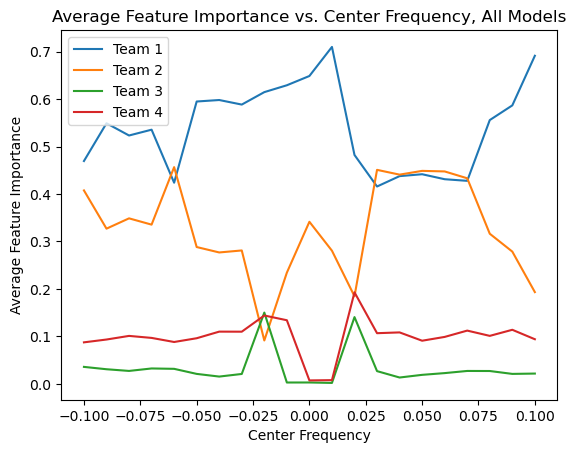

In [14]:
num_batches = 1
CHUNK_SIZE = 5000
num_examples = num_batches * CHUNK_SIZE
OBS_INT = 2048
NUM_ITERATIONS = 10

folder_version = 'cent_freqs'

team1_cf_dir = os.path.join(team1_test_dir, folder_version)
team2_cf_dir = os.path.join(team2_test_dir, folder_version)
team3_cf_dir = os.path.join(team3_test_dir, folder_version)
team4_cf_dir = os.path.join(team4_test_dir, folder_version)

cf_folder_names = []
processed_cfs = []
team1_importances = []
team2_importances = []
team3_importances = []
team4_importances = []

# Iterate over every folder in the center frequencies directory
for path, subdirs, files in os.walk(team1_cf_dir):
    # If we're in the top-level center frequency directory, get the values from all the folder names
    if os.path.basename(path) == folder_version:
        cf_folder_names = subdirs
    elif os.path.basename(path) in cf_folder_names:
        cf = float(os.path.basename(path))
        
        # Load the IQ and label data for this center frequency
        labels = load_labels(path, 1, num_batches, num_examples, OBS_INT)        
        team1_dataloader = load_data(os.path.join(team1_cf_dir, str(cf)), 1, num_batches, num_examples, TEAM1_OBS_INT)
        team2_dataloader = load_data(os.path.join(team2_cf_dir, str(cf)), 1, num_batches, num_examples, TEAM2_OBS_INT)
        team3_dataloader = load_data(os.path.join(team3_cf_dir, str(cf)), 1, num_batches, num_examples, TEAM3_OBS_INT)
        team4_dataloader = load_data(os.path.join(team4_cf_dir, str(cf)), 1, num_batches, num_examples, TEAM4_OBS_INT)
        print(f'Loaded data for center frequency {cf}')
        
        count_all_zeros = 0
        labels = np.squeeze(labels.numpy())
        for i in range(len(labels)):
            if np.sum(labels[i]) == 0:
                count_all_zeros += 1
        print("Number of missing labels:", count_all_zeros)
        
        print('Processing data...')
        # Extract features from Team 1's model
        team1_selected_layer.register_forward_hook(get_features('feats'))
        team1_model.to(device)
        team1_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team1_dataloader), desc='Team 1'):
            with torch.inference_mode():
                preds = team1_model(inputs.to(device))
            team1_feats_list.append(features['feats'].cpu().numpy())
        team1_feats_list = np.concatenate(team1_feats_list)
        features1 = np.array(team1_feats_list)
        features1 = torch.tensor(features1)
        features1 = features1.reshape(-1, features1.shape[-1])
        if features1.shape[1] != NUM_FEATS_T1:
            print(f'Error: Number of features extracted from team 1 model doesn\'t match expected value ({NUM_FEATS_T1})')
        
        # Extract features from Team 2's model
        team2_selected_layer.register_forward_hook(get_features('feats'))
        team2_model.to(device)
        team2_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team2_dataloader), desc='Team 2'):
            with torch.inference_mode():
                preds = team2_model(inputs.to(device))
            team2_feats_list.append(features['feats'].cpu().numpy())
        team2_feats_list = np.concatenate(team2_feats_list)
        features2 = np.array(team2_feats_list)
        features2 = torch.tensor(features2)
        features2 = features2.reshape(-1, features2.shape[-1])
        if features2.shape[1] != NUM_FEATS_T2:
            print(f'Error: Number of features extracted from team 2 model doesn\'t match expected value ({NUM_FEATS_T2})')
        
        # Extract features from Team 3's model
        team3_selected_layer.register_forward_hook(get_features('feats'))
        team3_model.to(device)
        team3_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team3_dataloader), desc='Team 3'):
            with torch.inference_mode():
                preds = team3_model(inputs.to(device))
            team3_feats_list.append(features['feats'].cpu().numpy())
        team3_feats_list = np.concatenate(team3_feats_list)
        features3 = np.array(team3_feats_list)
        features3 = torch.tensor(features3)
        features3 = features3.reshape(-1, features3.shape[-1])
        if features3.shape[1] != NUM_FEATS_T3:
            print(f'Error: Number of features extracted from team 3 model doesn\'t match expected value ({NUM_FEATS_T3})')
        
        # Extract features from team 4's model
        team4_selected_layer.register_forward_hook(get_features('feats'))
        team4_model.to(device)
        team4_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team4_dataloader), desc='Team 4'):
            with torch.inference_mode():
                preds = team4_model(inputs.to(device))
            team4_feats_list.append(features['feats'].cpu().numpy())
        team4_feats_list = np.concatenate(team4_feats_list)
        features4 = np.array(team4_feats_list)
        features4 = torch.tensor(features4)
        features4 = features4.reshape(-1, features4.shape[-1])
        if features4.shape[1] != NUM_FEATS_T4:
            print(f'Error: Number of features extracted from team 4 model doesn\'t match expected value ({NUM_FEATS_T4})')
        
        combined_tensor = torch.cat((features1, features2, features3, features4), dim=1)
        
        # Note: Decision tree classifiers use a stochastic algorithm so we take model importance as the average over multiple iterations
        team1_avg_importance = 0.0
        team2_avg_importance = 0.0
        team3_avg_importance = 0.0
        team4_avg_importance = 0.0
        for i in tqdm(range(NUM_ITERATIONS), desc='Getting model importances'):
            model = DecisionTreeClassifier()
            model.fit(combined_tensor, labels)
            importances = model.feature_importances_
            importances = np.array(importances)
        
            team1_avg_importance += np.sum(importances[ARRAY_START_IDX_T1:ARRAY_START_IDX_T2])
            team2_avg_importance += np.sum(importances[ARRAY_START_IDX_T2:ARRAY_START_IDX_T3])
            team3_avg_importance += np.sum(importances[ARRAY_START_IDX_T3:ARRAY_START_IDX_T4])
            team4_avg_importance += np.sum(importances[ARRAY_START_IDX_T4:len(importances)])
        team1_avg_importance /= NUM_ITERATIONS
        team2_avg_importance /= NUM_ITERATIONS
        team3_avg_importance /= NUM_ITERATIONS
        team4_avg_importance /= NUM_ITERATIONS
            
        importances_sum = team1_avg_importance + team2_avg_importance + team3_avg_importance + team4_avg_importance
        #print(f'Team 1 avg. importance: {team1_avg_importance}')
        #print(f'Team 2 avg. importance: {team2_avg_importance}')
        #print(f'Team 3 avg. importance: {team3_avg_importance}')
        #print(f'Team 4 avg. importance: {team4_avg_importance}')
        if not math.isclose(1.0, importances_sum, abs_tol=0.01):
            print(f'Error: Importances do not sum to 1.0 (Was {importances_sum})')
        
        processed_cfs.append(cf)
        team1_importances.append(team1_avg_importance)
        team2_importances.append(team2_avg_importance)
        team3_importances.append(team3_avg_importance)
        team4_importances.append(team4_avg_importance)

df = pd.DataFrame(
    {'cf': processed_cfs,
     'Team 1': team1_importances,
     'Team 2': team2_importances,
     'Team 3': team3_importances,
     'Team 4': team4_importances,
    })
print(df.to_string())
df.sort_values(by=['cf'], inplace=True)
df.plot.line(x='cf')

plt.ylabel('Average Feature Importance')
plt.xlabel('Center Frequency')
plt.title('Average Feature Importance vs. Center Frequency, All Models')
plt.savefig('../data/fusion_plots/feature_importances/avg_feat_importance_cf.png')
plt.show()

## Plot feature contribution over observation intervals

Loaded data for obs int 2048
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1672.87it/s]
Team 2: 5000it [00:03, 1416.01it/s]
Team 3: 5000it [00:01, 3873.22it/s]
Team 4: 5000it [00:01, 2540.64it/s]
Getting model importances: 100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


Loaded data for obs int 128
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2928.80it/s]
Team 2: 5000it [00:02, 2224.94it/s]
Team 3: 5000it [00:01, 3907.11it/s]
Team 4: 5000it [00:01, 2602.81it/s]
Getting model importances: 100%|██████████| 10/10 [01:06<00:00,  6.62s/it]


Loaded data for obs int 512
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2942.38it/s]
Team 2: 5000it [00:02, 2202.01it/s]
Team 3: 5000it [00:01, 2509.61it/s]
Team 4: 5000it [00:01, 2611.14it/s]
Getting model importances: 100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


Loaded data for obs int 256
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1912.97it/s]
Team 2: 5000it [00:02, 2099.40it/s]
Team 3: 5000it [00:01, 2656.62it/s]
Team 4: 5000it [00:02, 1942.18it/s]
Getting model importances: 100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


Loaded data for obs int 64
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2884.23it/s]
Team 2: 5000it [00:02, 2216.60it/s]
Team 3: 5000it [00:01, 3802.22it/s]
Team 4: 5000it [00:02, 1946.27it/s]
Getting model importances: 100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


Loaded data for obs int 1024
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2930.92it/s]
Team 2: 5000it [00:02, 2239.64it/s]
Team 3: 5000it [00:01, 3848.59it/s]
Team 4: 5000it [00:01, 2574.82it/s]
Getting model importances: 100%|██████████| 10/10 [00:39<00:00,  3.98s/it]

    obs    Team 1    Team 2    Team 3    Team 4
0  2048  0.955157  0.040218  0.002462  0.002163
1   128  0.076642  0.376930  0.023238  0.523190
2   512  0.178140  0.401935  0.149881  0.270043
3   256  0.046568  0.373547  0.018131  0.561754
4    64  0.183514  0.454500  0.052680  0.309305
5  1024  0.087608  0.890579  0.005766  0.016047


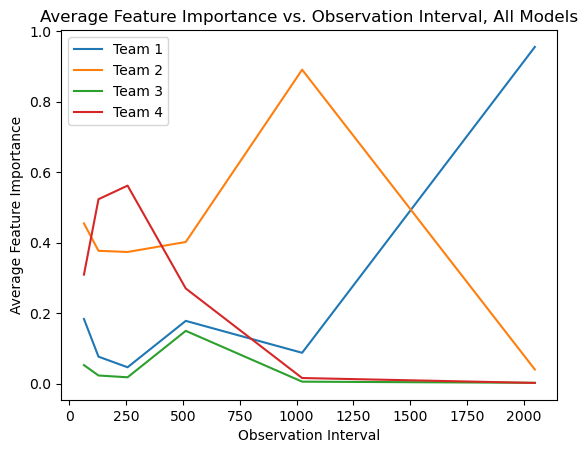

In [15]:
num_batches = 1
CHUNK_SIZE = 5000
num_examples = num_batches * CHUNK_SIZE
OBS_INT = 2048
NUM_ITERATIONS = 10

team1_obs_dir = os.path.join(team1_test_dir, 'obs_ints')
team2_obs_dir = os.path.join(team2_test_dir, 'obs_ints')
team3_obs_dir = os.path.join(team3_test_dir, 'obs_ints')
team4_obs_dir = os.path.join(team4_test_dir, 'obs_ints')

obs_folder_names = []
processed_obs = []
team1_importances = []
team2_importances = []
team3_importances = []
team4_importances = []

# Iterate over every folder in the obs int directory
for path, subdirs, files in os.walk(team1_obs_dir):
    # If we're in the top-level obs int directory, get the values from all the folder names
    if os.path.basename(path) == 'obs_ints':
        obs_folder_names = subdirs
    elif os.path.basename(path) in obs_folder_names:
        obs = int(os.path.basename(path))
        
        # Load the IQ and label data for this obs int
        labels = load_labels(path, 1, num_batches, num_examples, OBS_INT)        
        team1_dataloader = load_data(os.path.join(team1_obs_dir, str(obs)), 1, num_batches, num_examples, obs)
        team2_dataloader = load_data(os.path.join(team2_obs_dir, str(obs)), 1, num_batches, num_examples, obs)
        team3_dataloader = load_data(os.path.join(team3_obs_dir, str(obs)), 1, num_batches, num_examples, obs)
        team4_dataloader = load_data(os.path.join(team4_obs_dir, str(obs)), 1, num_batches, num_examples, obs)
        print(f'Loaded data for obs int {obs}')
        
        count_all_zeros = 0
        labels = np.squeeze(labels.numpy())
        for i in range(len(labels)):
            if np.sum(labels[i]) == 0:
                count_all_zeros += 1
        print("Number of missing labels:", count_all_zeros)
        
        print('Processing data...')
        # Extract features from Team 1's model
        team1_selected_layer.register_forward_hook(get_features('feats'))
        team1_model.to(device)
        team1_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team1_dataloader), desc='Team 1'):
            with torch.inference_mode():
                preds = team1_model(inputs.to(device))
            team1_feats_list.append(features['feats'].cpu().numpy())
        team1_feats_list = np.concatenate(team1_feats_list)
        features1 = np.array(team1_feats_list)
        features1 = torch.tensor(features1)
        features1 = features1.reshape(-1, features1.shape[-1])
        if features1.shape[1] != NUM_FEATS_T1:
            print(f'Error: Number of features extracted from team 1 model doesn\'t match expected value ({NUM_FEATS_T1})')
        
        # Extract features from Team 2's model
        team2_selected_layer.register_forward_hook(get_features('feats'))
        team2_model.to(device)
        team2_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team2_dataloader), desc='Team 2'):
            with torch.inference_mode():
                preds = team2_model(inputs.to(device))
            team2_feats_list.append(features['feats'].cpu().numpy())
        team2_feats_list = np.concatenate(team2_feats_list)
        features2 = np.array(team2_feats_list)
        features2 = torch.tensor(features2)
        features2 = features2.reshape(-1, features2.shape[-1])
        if features2.shape[1] != NUM_FEATS_T2:
            print(f'Error: Number of features extracted from team 2 model doesn\'t match expected value ({NUM_FEATS_T2})')
        
        # Extract features from Team 3's model
        team3_selected_layer.register_forward_hook(get_features('feats'))
        team3_model.to(device)
        team3_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team3_dataloader), desc='Team 3'):
            with torch.inference_mode():
                preds = team3_model(inputs.to(device))
            team3_feats_list.append(features['feats'].cpu().numpy())
        team3_feats_list = np.concatenate(team3_feats_list)
        features3 = np.array(team3_feats_list)
        features3 = torch.tensor(features3)
        features3 = features3.reshape(-1, features3.shape[-1])
        if features3.shape[1] != NUM_FEATS_T3:
            print(f'Error: Number of features extracted from team 3 model doesn\'t match expected value ({NUM_FEATS_T3})')
        
        # Extract features from team 4's model
        team4_selected_layer.register_forward_hook(get_features('feats'))
        team4_model.to(device)
        team4_feats_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team4_dataloader), desc='Team 4'):
            with torch.inference_mode():
                preds = team4_model(inputs.to(device))
            team4_feats_list.append(features['feats'].cpu().numpy())
        team4_feats_list = np.concatenate(team4_feats_list)
        features4 = np.array(team4_feats_list)
        features4 = torch.tensor(features4)
        features4 = features4.reshape(-1, features4.shape[-1])
        if features4.shape[1] != NUM_FEATS_T4:
            print(f'Error: Number of features extracted from team 4 model doesn\'t match expected value ({NUM_FEATS_T4})')
        
        combined_tensor = torch.cat((features1, features2, features3, features4), dim=1)
        
        # Note: Decision tree classifiers use a stochastic algorithm so we take model importance as the average over multiple iterations
        team1_avg_importance = 0.0
        team2_avg_importance = 0.0
        team3_avg_importance = 0.0
        team4_avg_importance = 0.0
        for i in tqdm(range(NUM_ITERATIONS), desc='Getting model importances'):
            model = DecisionTreeClassifier()
            model.fit(combined_tensor, labels)
            importances = model.feature_importances_
            importances = np.array(importances)
        
            team1_avg_importance += np.sum(importances[ARRAY_START_IDX_T1:ARRAY_START_IDX_T2])
            team2_avg_importance += np.sum(importances[ARRAY_START_IDX_T2:ARRAY_START_IDX_T3])
            team3_avg_importance += np.sum(importances[ARRAY_START_IDX_T3:ARRAY_START_IDX_T4])
            team4_avg_importance += np.sum(importances[ARRAY_START_IDX_T4:len(importances)])
        team1_avg_importance /= NUM_ITERATIONS
        team2_avg_importance /= NUM_ITERATIONS
        team3_avg_importance /= NUM_ITERATIONS
        team4_avg_importance /= NUM_ITERATIONS
            
        importances_sum = team1_avg_importance + team2_avg_importance + team3_avg_importance + team4_avg_importance
        #print(f'Team 1 avg. importance: {team1_avg_importance}')
        #print(f'Team 2 avg. importance: {team2_avg_importance}')
        #print(f'Team 3 avg. importance: {team3_avg_importance}')
        #print(f'Team 4 avg. importance: {team4_avg_importance}')
        if not math.isclose(1.0, importances_sum, abs_tol=0.01):
            print(f'Error: Importances do not sum to 1.0 (Was {importances_sum})')
        
        processed_obs.append(obs)
        team1_importances.append(team1_avg_importance)
        team2_importances.append(team2_avg_importance)
        team3_importances.append(team3_avg_importance)
        team4_importances.append(team4_avg_importance)

df = pd.DataFrame(
    {'obs': processed_obs,
     'Team 1': team1_importances,
     'Team 2': team2_importances,
     'Team 3': team3_importances,
     'Team 4': team4_importances,
    })
print(df.to_string())
df.sort_values(by=['obs'], inplace=True)
df.plot.line(x='obs')

plt.ylabel('Average Feature Importance')
plt.xlabel('Observation Interval')
plt.title('Average Feature Importance vs. Observation Interval, All Models')
plt.savefig('../data/fusion_plots/feature_importances/avg_feat_importance_obs_int.png')
plt.show()